# Purpose:

I want to test out the cluster labelling outputs of sciAnalysis as they seem to not be collapsing any size differences that ought to be called by the clustering algorithm.

In [88]:
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sciAnalysis import *
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
import pandas as pd
import sklearn.metrics as metrics
from sklearn.cluster import AgglomerativeClustering

In [5]:
def extrStates(states):
    #I am attempting to conform the reading of these known labels to the way that I have produced the HMM labels
    #within sciAnalysis so I can re-use code....
    state_tuples = []
    if len(states) > 1:
        for s in range(len(states)-1):
            state_tuples.append((states[s], states[s+1]))
    else:
        state_tuples.append(states[0])
    
    return state_tuples

def readCO(tsv, path):
    #Record only the individuals that are unique the sampling to get the true AF
    COs = []
    labels = []
    add_Mb = {'2L': 0, '2R': 23000000, '3L': 0, '3R': 24500000, 'X': 0}
    full_tsv = os.path.join(path, tsv)
    with open(full_tsv, 'r') as myTsv:
        TSV_reader = csv.reader(myTsv, delimiter='\t')

        index = 0
        for field in TSV_reader:
            #each individual will have an array of their breakpoints and their chromosome states
            chr2 = [int(pos)/1000000 for pos in field[2].split(',') if pos != ''] + [(int(pos) + add_Mb['2R'])/1000000 for pos in field[5].split(',') if pos != '']
            chr2_states = [int(segment) for segment in field[3].split(',')][:-1] + [int(segment) for segment in field[6].split(',')]
            refChr2 = extrStates(states=chr2_states)
            
            chr3 = [int(pos)/1000000 for pos in field[8].split(',') if pos != ''] + [(int(pos) + add_Mb['3R'] )/1000000for pos in field[11].split(',') if pos != '']
            chr3_states = [int(segment) for segment in field[9].split(',')][:-1] + [int(segment) for segment in field[12].split(',')]
            refChr3 = extrStates(states= chr3_states)
            
            chrx = [int(pos)/1000000 for pos in field[14].split(',') if pos != '']
            chrx_states = [int(segment) for segment in field[15].split(',')]
            refChrx = extrStates(states=chrx_states)
            
            all_labels = [refChr2, refChr3, refChrx]
            all_COS = [chr2, chr3, chrx]
            COs.append(all_COS)
            labels.append(all_labels)
            
            index += 1
            
    return COs, labels

def sciAnalysis_methods(CO_data, state_labels):
    myAnalysis = analyzeSEQ()
    myAnalysis.polarized_samples = myAnalysis.load_SNP_array(path='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/',
                                                            snp_array='SIZE_TEST_NEW.npy', encoding='latin1')
    myAnalysis.paintedGenome = [np.concatenate((myAnalysis.polarized_samples[0][0][:, 0], myAnalysis.polarized_samples[0][1][:, 0] + 23000000)) / 1000000,
                                np.concatenate((myAnalysis.polarized_samples[0][2][:, 0], myAnalysis.polarized_samples[0][3][:, 0] + 24500000)) / 1000000,
                                myAnalysis.polarized_samples[0][4][:, 0] / 1000000]

    SNP_pileup = []
    for sample in range(len(state_labels)):
        
        SNPs = myAnalysis.paintChromosome(breakpoints=CO_data[sample], labels=state_labels[sample])
        SNP_pileup.append(SNPs)
    
    for arm in range(3):
        myAnalysis.paintedGenome[arm] = np.vstack((myAnalysis.paintedGenome[arm], np.sum(np.vstack(np.vstack(SNP_pileup)[:,arm]), axis=0) / (2*len(state_labels)))).T
    
    #Compute SD params
    params, errs, AFs = myAnalysis.estimateSD_params(myAnalysis.paintedGenome)
    
    
    #Do the plotting
    with sns.axes_style('whitegrid'):
        fig = plt.figure(figsize=(12,5))
        sns.scatterplot(myAnalysis.paintedGenome[1][:,0], myAnalysis.paintedGenome[1][:,1],edgecolor=None, alpha=.1, color='black')
        plt.plot(AFs[1][:,0], AFs[1][:,1], linestyle='--', color='blue')
        plt.title('Chr3 theoretical pseudobulk')
        plt.xlabel('Mb')
        plt.ylabel('P2 AF')
        plt.show()
        plt.close()

    print('Driver strength: {0:.2f}'.format(params[1][0]*100))
    

In [3]:
calls = np.load('/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/SPARSE_BIG_SIZE_TESTclusters.npy')

### Testing theoretical AF from clustered:

SNP input loaded... 1997 cells read in...
Fitting parameters for segregation distortion inference and predicting allele frequencies...


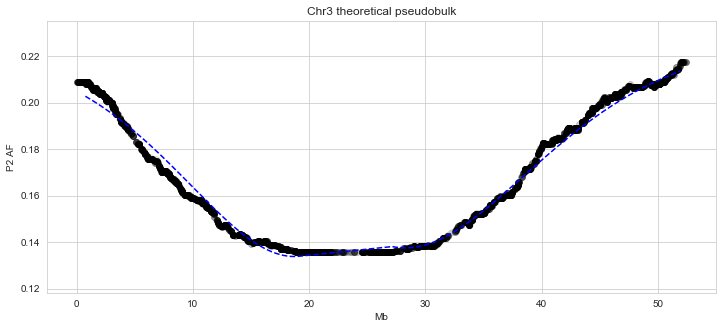

Driver strength: 23.57


In [8]:
co, labels = readCO(path='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/', tsv='BIG_SIZE_TEST_crossovers.tsv')

called_cos = []
called_labels = []
for i in calls:
    called_cos.append(co[i])
    called_labels.append(labels[i])
    
sciAnalysis_methods(called_cos, called_labels)

### Testing theoretical AF from un-clustered:

SNP input loaded... 1997 cells read in...
Fitting parameters for segregation distortion inference and predicting allele frequencies...


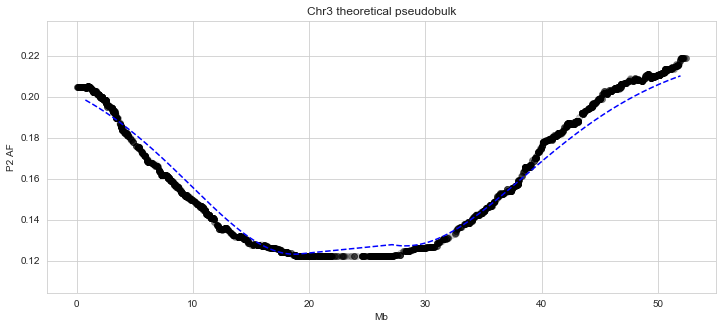

Driver strength: 25.73


In [11]:
sciAnalysis_methods(co, labels)

Clearly they individuals that I am calling from the clusters are still maintaining the same size distortion that is seen from not clustering individuals. It is only reducing the amount of size distortion by like 2% which is super weird and honestly terrible.

I'm going to play around with the posteriors and try use the clustering methods to try to debug this situation.

### Cluster toying:

In [12]:
CO_df = pd.read_csv('/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/BIG_SIZE_TEST_crossovers.tsv', header=None, sep='\t')

true_labels = CO_df.values[:,0]

posteriors = np.load('/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/SPARSE_BIG_SIZE_TEST_HMM_posteriors.npy')

In [74]:
#Block for PCA+tSNE
comps = PCA(n_components=20).fit_transform(posteriors)
tsne_embedding = TSNE(n_components=2, early_exaggeration=len(posteriors)/3, init='pca').fit_transform(comps)

cluster_labels = DBSCAN(eps=.15, min_samples=1).fit(tsne_embedding).labels_

ARI = metrics.adjusted_rand_score(cluster_labels, true_labels)
print(ARI)

0.6258240359171785


In [94]:
#Block for agglomerative on posteriors
cluster_labels = AgglomerativeClustering(n_clusters=None, compute_full_tree=True, distance_threshold=25, affinity='euclidean', linkage='ward').fit_predict(posteriors)
ARI = metrics.adjusted_rand_score(cluster_labels, true_labels)
print(ARI)

0.35285377753748487


In [91]:
c_table = {cluster:[] for cluster in cluster_labels}
index = 0
for cell in cluster_labels:
    c_table[cell].append(index)
    index += 1

SNP input loaded... 1997 cells read in...
Fitting parameters for segregation distortion inference and predicting allele frequencies...


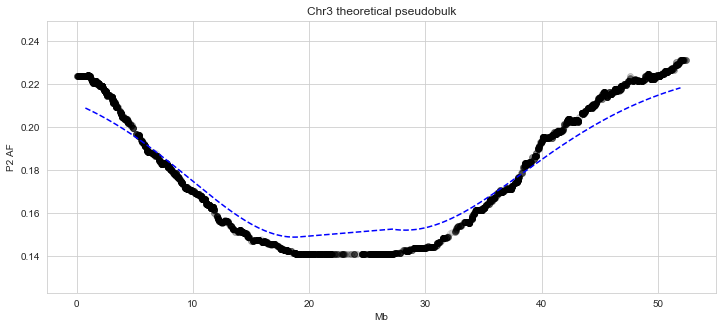

Driver strength: 20.49


In [92]:
collapsed = [np.random.choice(c_table[label]) for label in c_table.keys()]
co, labels = readCO(path='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/', tsv='BIG_SIZE_TEST_crossovers.tsv')

called_cos = []
called_labels = []
for i in collapsed:
    called_cos.append(co[i])
    called_labels.append(labels[i])
    
sciAnalysis_methods(called_cos, called_labels)

### Conclusion:

The clustering approach does not seem to be working in reducing the size differences very well. It only reduces it by a couple of percent at best. This clustering approach seems like it may be completely intractable for this problem.